In [1]:
import shutil
import os
import numpy as np
import pandas as pd
import random
import time

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, roc_auc_score, auc, precision_recall_curve, roc_curve, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2


from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

from imageai.Detection import ObjectDetection

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT_DIR = '../dataset/Images/*/*'
seed = 42

# Utility functions : Loading data

In [3]:
def load_data_to_df(path, path_indice : int=8):
    imgs = []
    paths = []
    breed  = []
    height, width = [], []

    for folder in tqdm(glob(os.path.abspath(path)), desc="Loading data ... : "):
        img = cv2.imread(folder)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        paths.append(folder)
        height.append(img.shape[0])
        width.append(img.shape[1])
        breed.append(folder.split("/")[path_indice].split("-", 1)[1])
    df = pd.DataFrame({'img' : imgs, 'path': paths, 'breed': breed, 'height': height, 'width': width})
    df['breed'] = df['breed'].str.lower().str.replace("_", " ")
    return df

def copy_img(split_df, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for i, path in tqdm(split_df["path"].items()):
        label_folder = os.path.join(folder, split_df.loc[i, "breed"])
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        image_name = path.split(os.path.sep)[-1]
        destination = os.path.join(label_folder, image_name)
        shutil.copy(path, destination)

def load_dataset_and_detect(paths: str, model: str, minimum_percentage_probability: float=50., path_indice : int=8):
    df = pd.DataFrame(columns=[['img', 'path', 'breed', 'perc_details', "confidence_percentage", "nb_dog"] + [f"crop_img_{i}"for i  in range(7)]])
    df.columns = df.columns.get_level_values(0)
    # print(type(df.columns))
    execution_path = os.getcwd()

    detector = ObjectDetection()
    if model == "yolo_v3":
        detector.setModelTypeAsYOLOv3()
        detector.setModelPath(os.path.join(execution_path , "models/yolov3.pt"))
    if model == "tiny-yolo_v3":
        detector.setModelTypeAsTinyYOLOv3()
        detector.setModelPath(os.path.join(execution_path, "models/tiny-yolov3.pt"))
    if model == "retina":
        detector.setModelTypeAsRetinaNet()
        detector.setModelPath(os.path.join(execution_path , "models/retinanet_resnet50_fpn_coco-eeacb38b.pth"))

    detector.loadModel()

    custom_objects = detector.CustomObjects(dog=True)


    for idx, folder in enumerate(tqdm(glob(os.path.abspath(paths)), desc="Loading data ... : ")):
        detections  = detector.detectObjectsFromImage(output_type="array", custom_objects=custom_objects, input_image=folder, minimum_percentage_probability=minimum_percentage_probability, extract_detected_objects=True)
        img = cv2.imread(folder)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        df.at[idx , "img"] = img
        df.loc[idx , "path"] = folder
        df.loc[idx , "breed"] = folder.split("/")[path_indice].split("-", 1)[1]


        if detections[1]:

            df.at[idx , "perc_details"] = detections[1]

            df.loc[idx , "nb_dog"] = int(len(detections[2]))
            df.loc[idx , "confidence_percentage"] = float(detections[1][0]["percentage_probability"])
            for i  in range(len(detections[2])):
                df.at[idx , f"crop_img_{i}"] = detections[2][i]
                if i == 6:
                    break
        else:
            df.at[idx , f"crop_img_0"] = img
            df.loc[idx , "perc_details"] = "not detected"
            df.loc[idx , "nb_dog"] = 1

    df['breed'] = df['breed'].str.lower().str.replace("_", " ")
    df["confidence_percentage"] = pd.to_numeric(df["confidence_percentage"], errors='coerce')
    df["nb_dog"] = pd.to_numeric(df["nb_dog"], errors='coerce')
    return df

In [4]:
df = load_data_to_df(DATA_ROOT_DIR, 8)

Loading data ... :   0%|          | 0/20580 [00:00<?, ?it/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     20580 non-null  object
 1   path    20580 non-null  object
 2   breed   20580 non-null  object
 3   height  20580 non-null  int64 
 4   width   20580 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 804.0+ KB


In [6]:
df_detect = load_dataset_and_detect(DATA_ROOT_DIR, "retina", 60, 8)

/home/alex/Bureau/OpenClassroom/projet_6/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_6/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/alex/Bureau/OpenClassroom/projet_6/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_6/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a wei

Loading data ... :   0%|          | 0/20580 [00:00<?, ?it/s]

In [7]:
df_detect.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20580 entries, 0 to 20579
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   img                    20580 non-null  object 
 1   path                   20580 non-null  object 
 2   breed                  20580 non-null  object 
 3   perc_details           20580 non-null  object 
 4   confidence_percentage  18658 non-null  float64
 5   nb_dog                 20580 non-null  int64  
 6   crop_img_0             20580 non-null  object 
 7   crop_img_1             1638 non-null   object 
 8   crop_img_2             200 non-null    object 
 9   crop_img_3             23 non-null     object 
 10  crop_img_4             4 non-null      object 
 11  crop_img_5             2 non-null      object 
 12  crop_img_6             1 non-null      object 
dtypes: float64(1), int64(1), object(11)
memory usage: 2.7+ MB


In [8]:
df_detect["confidence_percentage"].describe()

count    18658.000000
mean        86.237513
std          9.026104
min         60.000000
25%         81.120000
50%         88.530000
75%         93.390000
max         99.280000
Name: confidence_percentage, dtype: float64

In [9]:
df_detect = df_detect[df_detect["nb_dog"] == 1]

In [10]:
df_detect.shape

(18942, 13)

# Utility functions : plotting

# Utility functions : dataset

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [12]:
def split_df(df, input_col: str, rs : int=seed):
    Xy = df[[input_col, "breed"]]
    train, test = train_test_split(
        Xy, test_size=0.2, random_state=rs, stratify=df['breed'])
    train, valid = train_test_split(
        train, test_size=0.1, random_state=rs, stratify=train['breed'])
    return train, test, valid

In [13]:
def map_class(df):
    idx2label = {id:key for id, key in enumerate(df["breed"].unique())}
    label2idx = {key:id for id, key in enumerate(df["breed"].unique())}
    return idx2label, label2idx


class StanfordDogDataset(Dataset):
    def __init__(self, ds, class_map, transform=None, calc_mean=False):
        self.images_filepaths = ds["path"].to_list()
        self.label = ds["breed"].to_list()
        self.label_map = class_map
        self.transform = transform
        self.calc_mean = calc_mean

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]

        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.calc_mean:
            image = Image.open(image_filepath)
            if image.mode == "RGBA":
                # One picture is in 4 channels when open with PIL ??????? but not with openCV
                image = Image.open(image_filepath).convert("RGB")
        class_id = self.label_map[self.label[idx]]
        # class_id = torch.tensor(class_id)

        if self.transform is not None:
            image = self.transform(image=image)["image"] if not self.calc_mean else self.transform(image)

        return image, class_id

class StanfordDogDatasetFromArray(Dataset):
    def __init__(self, ds, class_map, transform=None, calc_mean=False):
        self.images = ds["crop_img_0"].to_list()
        self.label = ds["breed"].to_list()
        self.label_map = class_map
        self.transform = transform
        self.calc_mean = calc_mean

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]

        class_id = self.label_map[self.label[idx]]

        if self.transform is not None:
            image = self.transform(image=image)["image"] if not self.calc_mean else self.transform(image)

        return image, class_id

def calculate_means_std(dataset_cls, ds_train_df):
    tranformed_dataset = dataset_cls(ds=ds_train_df, class_map=label2idx, transform=transforms.ToTensor(), calc_mean=True)
    means = torch.zeros(3)
    stds = torch.zeros(3)

    for img, label in tqdm(tranformed_dataset, desc="Mean & stds"):
        means += torch.mean(img, dim = (1,2))
        stds += torch.std(img, dim = (1,2))

    means /= len(tranformed_dataset)
    stds /= len(tranformed_dataset)

    print(f'Calculated means: {means}')
    print(f'Calculated stds: {stds}')
    return means, stds

In [14]:
# Training transforms.

def train_transforms(img_size):
    train_transform = A.Compose(

        [     A.Resize(width=img_size, height=img_size),
              A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.1),
              A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
              A.OneOf([
                  A.Blur(blur_limit=3, p=0.5),
                  A.ColorJitter(p=0.5),
              ], p=1.0),
              A.Normalize(
                  mean=means,
                  std=stds,
                  max_pixel_value=255,
              ),
              ToTensorV2(),
              ]
    )


    return train_transform

# Validation transforms.
def valid_transforms(img_size):
    valid_transform = A.Compose(
        [
            A.Resize(width=img_size, height=img_size),
            A.Normalize(mean=means, std=stds),
            ToTensorV2(),
        ]
    )
    return valid_transform


def get_datasets(img_size :int, class_dataset, no_aug : bool = False):
    train_dataset = class_dataset(ds=train_df, class_map=label2idx ,transform=train_transforms(img_size)) if not no_aug else class_dataset(ds=train_df, class_map=label2idx, transform=valid_transforms(img_size))
    val_dataset = class_dataset(ds=valid_df, class_map=label2idx, transform=valid_transforms(img_size))
    test_dataset = class_dataset(ds=test_df, class_map=label2idx, transform=valid_transforms(img_size))
    print(f'Number of training examples: {len(train_dataset)}')
    print(f'Number of validation examples: {len(val_dataset)}')
    print(f'Number of testing examples: {len(test_dataset)}')
    return (
        train_dataset, val_dataset,
        test_dataset
    )

def get_data_loaders(train_dataset, valid_dataset, test_dataset,
        batch_size, num_workers):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False,

        num_workers=num_workers, pin_memory=True
    )
    return train_loader, val_loader, test_loader

# Utility functions : training & evaluating

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
def plot_training(train_data, model_name):
    df_res = pd.DataFrame(train_data, columns=["train_loss", "train_acc", "valid_loss", "valid_acc"])
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].plot(df_res.train_loss, label='train')
    ax[0].plot(df_res.valid_loss, label='valid')
    ax[0].set_title(f'Training / validation loss')
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)

    ax[1].plot(df_res.train_acc, label='train')
    ax[1].plot(df_res.valid_acc, label='valid')
    ax[1].set_title(f'Training / validation accuracy')
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)

    plt.legend()
    fig.savefig(f'./models/training/{model_name}_{time.strftime("%Y%m%d-%H%M%S")}.png', dpi=fig.dpi)
    plt.show()

    return df_res

def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)
            # y_pred, _ = model(x)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d',
            cmap='Blues',
            ax=ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)
    plt.tight_layout()
    plt.show()

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label.item()]
        incorrect_class = classes[incorrect_label.item()]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)
    plt.show()

def plot_gradcam(incorrect, classes, n_images, model, target_layers):

    cam = GradCAM(model=model, target_layers=[target_layers], use_cuda=True)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        grayscale_cam = cam(input_tensor=image.unsqueeze(0))
        grayscale_cam = grayscale_cam[0, :]

        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label.item()]
        incorrect_class = classes[incorrect_label.item()]


        image = normalize_image(image)
        visualization = show_cam_on_image(image.cpu().numpy(), grayscale_cam, use_rgb=True)


        ax.imshow(visualization)
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)
    plt.show()


# Train model from scratch : custom  CNN

In [17]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 9 * 9)
        x = self.classifier(x)
        return x

In [18]:
params = {
    "model": "custom-cnn-model",
    "lr": 0.0001,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 10,
}

In [19]:
train_df, test_df, valid_df = split_df(df, "path")

In [20]:
idx2label, label2idx = map_class(df)

In [21]:
means, stds = calculate_means_std(StanfordDogDataset, train_df)

Mean & stds:   0%|          | 0/14817 [00:00<?, ?it/s]

Calculated means: tensor([0.4768, 0.4529, 0.3919])
Calculated stds: tensor([0.2334, 0.2287, 0.2269])


In [22]:
train_dataset, val_dataset, test_dataset = get_datasets(img_size=32, class_dataset=StanfordDogDataset, no_aug=True)

Number of training examples: 14817
Number of validation examples: 1647
Number of testing examples: 4116


In [23]:
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"], num_workers=params["num_workers"])

In [24]:
custom_model = ConvNet(len(idx2label)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(custom_model.parameters(), lr=params["lr"], momentum=0.9)
print(f'The model has {count_parameters(custom_model):,} trainable parameters')

The model has 5,446,136 trainable parameters


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 4.721 | Train Acc: 1.75%
	 Val. Loss: 4.584 |  Val. Acc: 2.97%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 4.495 | Train Acc: 3.50%
	 Val. Loss: 4.411 |  Val. Acc: 4.31%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 4.296 | Train Acc: 5.61%
	 Val. Loss: 4.278 |  Val. Acc: 5.29%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 4.147 | Train Acc: 7.65%
	 Val. Loss: 4.195 |  Val. Acc: 6.38%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 4.020 | Train Acc: 9.88%
	 Val. Loss: 4.158 |  Val. Acc: 6.26%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 27s
	Train Loss: 3.881 | Train Acc: 11.77%
	 Val. Loss: 4.104 |  Val. Acc: 8.14%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 3.736 | Train Acc: 14.41%
	 Val. Loss: 4.086 |  Val. Acc: 8.20%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 3.564 | Train Acc: 17.19%
	 Val. Loss: 4.090 |  Val. Acc: 9.11%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 3.362 | Train Acc: 21.18%
	 Val. Loss: 4.117 |  Val. Acc: 10.02%


Training:   0%|          | 0/927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 27s
	Train Loss: 3.117 | Train Acc: 25.11%
	 Val. Loss: 4.151 |  Val. Acc: 9.17%


FileNotFoundError: [Errno 2] No such file or directory: './models/training/custom-cnn-model_20230628-171140.png'

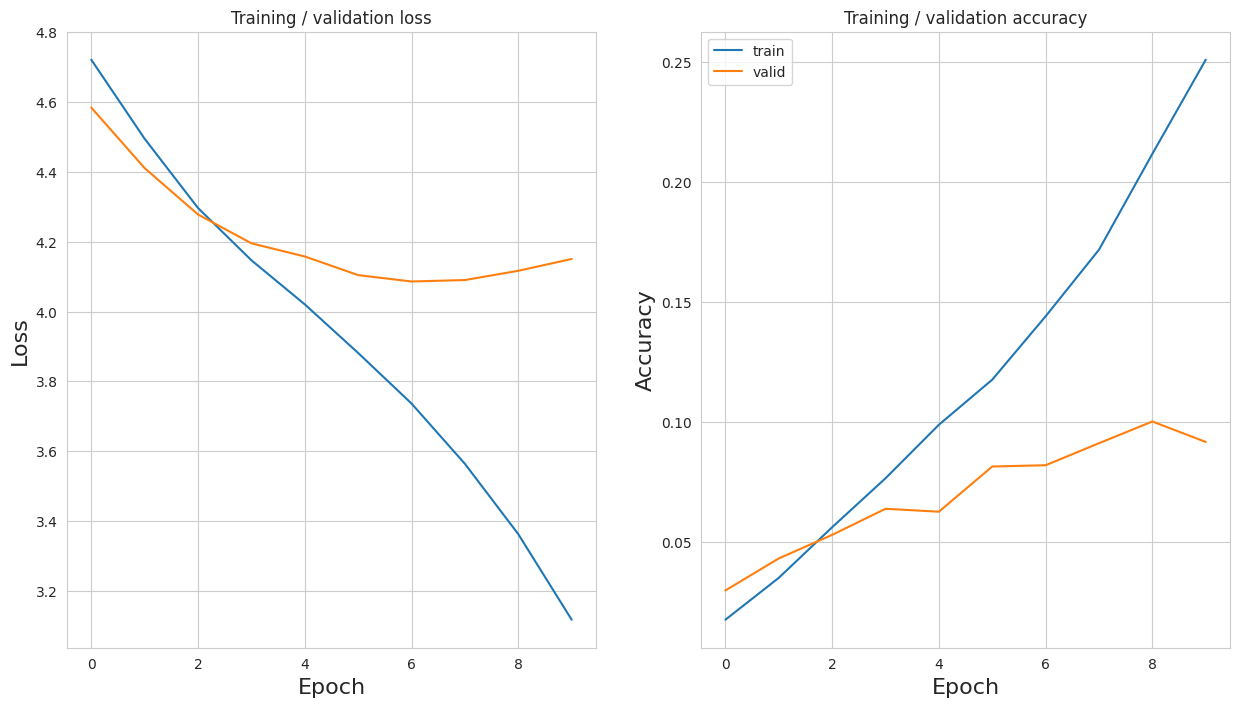

In [25]:
if os.path.isfile(f'./models/{params["model"]}.h5'):
    custom_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:
    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(custom_model, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(custom_model, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    plot_training(train_data, params["model"])

## With detection

In [ ]:
params = {
    "model": "custom-cnn-model_1",
    "lr": 0.0001,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 10,
}
train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=32, class_dataset=StanfordDogDatasetFromArray, no_aug=True)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"],
                                                         num_workers=params["num_workers"])

In [ ]:
custom_model_1 = ConvNet(len(idx2label)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(custom_model_1.parameters(), lr=params["lr"], momentum=0.9)
print(f'The model has {count_parameters(custom_model_1):,} trainable parameters')

if os.path.isfile(f'./models/{params["model"]}.h5'):
    custom_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:
    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(custom_model_1, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(custom_model_1, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    plot_training(train_data, params["model"])

## With aug & detection

In [ ]:
params = {
    "model": "custom-cnn-model_2",
    "lr": 0.0001,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 10,
}
train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=32, class_dataset=StanfordDogDatasetFromArray)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"],
                                                         num_workers=params["num_workers"])
custom_model_1 = ConvNet(len(idx2label)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(custom_model_1.parameters(), lr=params["lr"], momentum=0.9)
print(f'The model has {count_parameters(custom_model_1):,} trainable parameters')

if os.path.isfile(f'./models/{params["model"]}.h5'):
    custom_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:
    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(custom_model_1, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(custom_model_1, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    plot_training(train_data, params["model"])

# Train model from scratch : VGG

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        # return x, h
        return x


vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [ ]:
params = {
    "model": "custom-vgg-model",
    "lr": 0.0001,
    "batch_size": 32,
    "num_workers": 0,
    "epochs": 100,
}

In [ ]:
train_df, test_df, valid_df = split_df(df, "path")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDataset, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDataset)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=params["batch_size"], num_workers=params["num_workers"])

In [ ]:
vgg_model = VGG(vgg11_layers, len(idx2label)).to(device)
optimizer = optim.Adam(vgg_model.parameters(), lr=params["lr"])

# optimizer = torch.optim.SGD(vgg_model.parameters(), lr=params["lr"], momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)
print(f'The model has {count_parameters(vgg_model):,} trainable parameters')

In [ ]:
if os.path.isfile(f'./models/{params["model"]}.h5'):
    vgg_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:

    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(vgg_model, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(vgg_model, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(vgg_model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    plot_training(train_data, params["model"])

## With detect

In [ ]:
params = {
    "model": "custom-vgg-model_1",
    "lr": 0.0001,
    "batch_size": 32,
    "num_workers": 0,
    "epochs": 100,
}
train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDatasetFromArray)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"],
                                                         num_workers=params["num_workers"])

In [ ]:
vgg_model_1 = VGG(vgg11_layers, len(idx2label)).to(device)
optimizer = optim.Adam(vgg_model_1.parameters(), lr=params["lr"])

# optimizer = torch.optim.SGD(vgg_model.parameters(), lr=params["lr"], momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)
print(f'The model has {count_parameters(vgg_model_1):,} trainable parameters')
if os.path.isfile(f'./models/{params["model"]}.h5'):
    vgg_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:

    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(vgg_model_1, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(vgg_model_1, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(vgg_model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    plot_training(train_data, params["model"])

## no aug & detect

In [ ]:
params = {
    "model": "custom-vgg-model_2",
    "lr": 0.0001,
    "batch_size": 32,
    "num_workers": 0,
    "epochs": 100,
}
train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDatasetFromArray)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"],
                                                         num_workers=params["num_workers"])

vgg_model_2 = VGG(vgg11_layers, len(idx2label)).to(device)
optimizer = optim.Adam(vgg_model_2.parameters(), lr=params["lr"])

# optimizer = torch.optim.SGD(vgg_model.parameters(), lr=params["lr"], momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)
print(f'The model has {count_parameters(vgg_model_2):,} trainable parameters')
if os.path.isfile(f'./models/{params["model"]}.h5'):
    vgg_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:

    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(vgg_model_2, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(vgg_model_2, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(vgg_model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    plot_training(train_data, params["model"])

# Transfer learning : Resnet50

In [ ]:
params = {
    "model": "resnet50-transfer_learning",
    "lr": 1e-3,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 60,
}

In [ ]:
train_df, test_df, valid_df = split_df(df, "path")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDataset, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDataset)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"],
                                                         num_workers=params["num_workers"])



In [ ]:
pretrained_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(idx2label)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
optimizer = optim.Adam(pretrained_model.parameters(), lr=params["lr"])

criterion = nn.CrossEntropyLoss()
pretrained_model = pretrained_model.to(device)
criterion = criterion.to(device)

In [ ]:
if os.path.isfile(f'./models/{params["model"]}.h5'):
    pretrained_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:

    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(pretrained_model, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(pretrained_model, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(pretrained_model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    plot_training(train_data, params["model"])

# with detect

In [16]:
params = {
    "model": "resnet50-transfer_learning_1",
    "lr": 1e-3,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 60,
}

train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDatasetFromArray)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"],
                                                         num_workers=params["num_workers"])

pretrained_model_1 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
IN_FEATURES = pretrained_model_1.fc.in_features
OUTPUT_DIM = len(idx2label)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model_1.fc = fc
optimizer = optim.Adam(pretrained_model_1.parameters(), lr=params["lr"])
pretrained_model_1 = pretrained_model_1.to(device)
criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)
if os.path.isfile(f'./models/{params["model"]}.h5'):
    pretrained_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:

    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(pretrained_model_1, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(pretrained_model_1, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(pretrained_model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    plot_training(train_data, params["model"])


Mean & stds:   0%|          | 0/13860 [00:00<?, ?it/s]

Calculated means: tensor([0.3924, 0.4409, 0.4685])
Calculated stds: tensor([0.2277, 0.2308, 0.2348])
Number of training examples: 13860
Number of validation examples: 1540
Number of testing examples: 3851


Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 30s
	Train Loss: 4.049 | Train Acc: 8.20%
	 Val. Loss: 3.203 |  Val. Acc: 19.52%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 29s
	Train Loss: 3.034 | Train Acc: 22.28%
	 Val. Loss: 2.522 |  Val. Acc: 31.19%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 30s
	Train Loss: 2.510 | Train Acc: 32.43%
	 Val. Loss: 2.062 |  Val. Acc: 41.69%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 29s
	Train Loss: 2.198 | Train Acc: 39.94%
	 Val. Loss: 1.751 |  Val. Acc: 49.23%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 30s
	Train Loss: 1.953 | Train Acc: 45.34%
	 Val. Loss: 1.605 |  Val. Acc: 54.32%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 31s
	Train Loss: 1.762 | Train Acc: 50.00%
	 Val. Loss: 1.556 |  Val. Acc: 53.16%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 29s
	Train Loss: 1.626 | Train Acc: 53.47%
	 Val. Loss: 1.562 |  Val. Acc: 54.57%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 30s
	Train Loss: 1.496 | Train Acc: 56.82%
	 Val. Loss: 1.423 |  Val. Acc: 59.28%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 30s
	Train Loss: 1.391 | Train Acc: 59.79%
	 Val. Loss: 1.335 |  Val. Acc: 60.18%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 30s
	Train Loss: 1.286 | Train Acc: 62.19%
	 Val. Loss: 1.346 |  Val. Acc: 61.28%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 30s
	Train Loss: 1.196 | Train Acc: 64.43%
	 Val. Loss: 1.536 |  Val. Acc: 56.77%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 30s
	Train Loss: 1.102 | Train Acc: 67.39%
	 Val. Loss: 1.253 |  Val. Acc: 63.47%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 30s
	Train Loss: 1.033 | Train Acc: 68.69%
	 Val. Loss: 1.235 |  Val. Acc: 65.53%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 30s
	Train Loss: 0.961 | Train Acc: 71.28%
	 Val. Loss: 1.335 |  Val. Acc: 62.89%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 30s
	Train Loss: 0.885 | Train Acc: 72.67%
	 Val. Loss: 1.237 |  Val. Acc: 63.27%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 30s
	Train Loss: 0.834 | Train Acc: 74.17%
	 Val. Loss: 1.324 |  Val. Acc: 64.11%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 1m 31s
	Train Loss: 0.768 | Train Acc: 76.43%
	 Val. Loss: 1.521 |  Val. Acc: 60.05%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 32s
	Train Loss: 0.712 | Train Acc: 77.84%
	 Val. Loss: 1.431 |  Val. Acc: 64.95%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 1m 33s
	Train Loss: 0.675 | Train Acc: 79.22%
	 Val. Loss: 1.351 |  Val. Acc: 63.60%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 32s
	Train Loss: 0.631 | Train Acc: 80.46%
	 Val. Loss: 1.344 |  Val. Acc: 63.92%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 1m 32s
	Train Loss: 0.569 | Train Acc: 82.18%
	 Val. Loss: 1.344 |  Val. Acc: 64.24%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 33s
	Train Loss: 0.542 | Train Acc: 82.66%
	 Val. Loss: 1.354 |  Val. Acc: 65.14%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 1m 31s
	Train Loss: 0.508 | Train Acc: 84.26%
	 Val. Loss: 1.349 |  Val. Acc: 64.56%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 1m 34s
	Train Loss: 0.463 | Train Acc: 85.40%
	 Val. Loss: 1.425 |  Val. Acc: 65.53%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 1m 40s
	Train Loss: 0.439 | Train Acc: 86.36%
	 Val. Loss: 1.511 |  Val. Acc: 64.05%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 1m 29s
	Train Loss: 0.418 | Train Acc: 86.87%
	 Val. Loss: 1.530 |  Val. Acc: 62.89%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 1m 29s
	Train Loss: 0.397 | Train Acc: 87.37%
	 Val. Loss: 1.541 |  Val. Acc: 63.27%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 1m 29s
	Train Loss: 0.362 | Train Acc: 88.75%
	 Val. Loss: 1.594 |  Val. Acc: 64.18%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 1m 32s
	Train Loss: 0.355 | Train Acc: 88.91%
	 Val. Loss: 1.549 |  Val. Acc: 65.79%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 1m 28s
	Train Loss: 0.340 | Train Acc: 89.37%
	 Val. Loss: 1.496 |  Val. Acc: 64.37%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 1m 28s
	Train Loss: 0.317 | Train Acc: 90.02%
	 Val. Loss: 1.582 |  Val. Acc: 65.08%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 1m 29s
	Train Loss: 0.306 | Train Acc: 90.34%
	 Val. Loss: 1.569 |  Val. Acc: 64.43%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 1m 31s
	Train Loss: 0.285 | Train Acc: 91.41%
	 Val. Loss: 1.664 |  Val. Acc: 62.82%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 1m 33s
	Train Loss: 0.282 | Train Acc: 91.14%
	 Val. Loss: 1.718 |  Val. Acc: 63.08%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 1m 32s
	Train Loss: 0.274 | Train Acc: 91.03%
	 Val. Loss: 1.591 |  Val. Acc: 65.14%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 1m 31s
	Train Loss: 0.249 | Train Acc: 92.35%
	 Val. Loss: 1.637 |  Val. Acc: 63.47%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 1m 33s
	Train Loss: 0.252 | Train Acc: 92.16%
	 Val. Loss: 1.687 |  Val. Acc: 63.72%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 1m 31s
	Train Loss: 0.233 | Train Acc: 92.76%
	 Val. Loss: 1.832 |  Val. Acc: 61.73%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 1m 33s
	Train Loss: 0.223 | Train Acc: 93.05%
	 Val. Loss: 1.678 |  Val. Acc: 63.72%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 1m 31s
	Train Loss: 0.226 | Train Acc: 93.06%
	 Val. Loss: 1.748 |  Val. Acc: 62.44%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 1m 32s
	Train Loss: 0.216 | Train Acc: 93.45%
	 Val. Loss: 1.716 |  Val. Acc: 65.53%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 1m 30s
	Train Loss: 0.202 | Train Acc: 93.64%
	 Val. Loss: 1.762 |  Val. Acc: 62.82%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 1m 28s
	Train Loss: 0.192 | Train Acc: 94.07%
	 Val. Loss: 1.752 |  Val. Acc: 63.53%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 1m 28s
	Train Loss: 0.197 | Train Acc: 93.76%
	 Val. Loss: 1.739 |  Val. Acc: 63.92%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 1m 30s
	Train Loss: 0.192 | Train Acc: 94.06%
	 Val. Loss: 1.710 |  Val. Acc: 65.53%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 1m 28s
	Train Loss: 0.201 | Train Acc: 93.65%
	 Val. Loss: 1.796 |  Val. Acc: 64.30%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 1m 28s
	Train Loss: 0.169 | Train Acc: 94.84%
	 Val. Loss: 1.807 |  Val. Acc: 65.01%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 1m 28s
	Train Loss: 0.176 | Train Acc: 94.40%
	 Val. Loss: 1.682 |  Val. Acc: 65.40%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 1m 28s
	Train Loss: 0.157 | Train Acc: 95.27%
	 Val. Loss: 1.869 |  Val. Acc: 63.72%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 1m 28s
	Train Loss: 0.167 | Train Acc: 94.77%
	 Val. Loss: 1.741 |  Val. Acc: 65.21%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 51 | Epoch Time: 1m 27s
	Train Loss: 0.158 | Train Acc: 94.88%
	 Val. Loss: 1.738 |  Val. Acc: 64.18%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 1m 27s
	Train Loss: 0.158 | Train Acc: 95.31%
	 Val. Loss: 1.713 |  Val. Acc: 67.14%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 53 | Epoch Time: 1m 29s
	Train Loss: 0.148 | Train Acc: 95.22%
	 Val. Loss: 1.848 |  Val. Acc: 65.85%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 1m 32s
	Train Loss: 0.161 | Train Acc: 95.17%
	 Val. Loss: 1.956 |  Val. Acc: 64.37%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 55 | Epoch Time: 1m 32s
	Train Loss: 0.140 | Train Acc: 95.76%
	 Val. Loss: 1.775 |  Val. Acc: 64.43%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 1m 33s
	Train Loss: 0.142 | Train Acc: 95.59%
	 Val. Loss: 1.815 |  Val. Acc: 65.66%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 57 | Epoch Time: 1m 33s
	Train Loss: 0.146 | Train Acc: 95.53%
	 Val. Loss: 1.829 |  Val. Acc: 64.11%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 1m 33s
	Train Loss: 0.135 | Train Acc: 95.85%
	 Val. Loss: 1.857 |  Val. Acc: 64.11%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 59 | Epoch Time: 1m 32s
	Train Loss: 0.126 | Train Acc: 96.02%
	 Val. Loss: 1.955 |  Val. Acc: 64.30%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 1m 28s
	Train Loss: 0.129 | Train Acc: 96.17%
	 Val. Loss: 1.834 |  Val. Acc: 64.11%


NameError: name 'plot_training' is not defined

## with others weighs

In [19]:
params = {
    "model": "resnet50-transfer_learning_2",
    "lr": 1e-3,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 60,
}

train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDatasetFromArray)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"],
                                                         num_workers=params["num_workers"])

pretrained_model_2 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
IN_FEATURES = pretrained_model_2.fc.in_features
OUTPUT_DIM = len(idx2label)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model_2.fc = fc
optimizer = optim.Adam(pretrained_model_2.parameters(), lr=params["lr"])

criterion = nn.CrossEntropyLoss()
pretrained_model_2 = pretrained_model_2.to(device)
criterion = criterion.to(device)
if os.path.isfile(f'./models/{params["model"]}.h5'):
    pretrained_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:

    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(pretrained_model_2, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(pretrained_model_2, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(pretrained_model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    plot_training(train_data, params["model"])


Mean & stds:   0%|          | 0/13860 [00:00<?, ?it/s]

Calculated means: tensor([0.3924, 0.4409, 0.4685])
Calculated stds: tensor([0.2277, 0.2308, 0.2348])
Number of training examples: 13860
Number of validation examples: 1540
Number of testing examples: 3851


Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 28s
	Train Loss: 4.774 | Train Acc: 1.42%
	 Val. Loss: 4.585 |  Val. Acc: 2.06%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 32s
	Train Loss: 4.587 | Train Acc: 2.51%
	 Val. Loss: 4.415 |  Val. Acc: 3.16%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 35s
	Train Loss: 4.462 | Train Acc: 3.19%
	 Val. Loss: 4.407 |  Val. Acc: 3.09%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 34s
	Train Loss: 4.331 | Train Acc: 4.28%
	 Val. Loss: 4.154 |  Val. Acc: 5.86%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 34s
	Train Loss: 4.190 | Train Acc: 5.94%
	 Val. Loss: 3.973 |  Val. Acc: 6.96%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 34s
	Train Loss: 4.067 | Train Acc: 7.06%
	 Val. Loss: 3.848 |  Val. Acc: 8.38%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 30s
	Train Loss: 3.936 | Train Acc: 8.69%
	 Val. Loss: 3.795 |  Val. Acc: 9.21%


Training:   0%|          | 0/867 [00:00<?, ?it/s]

## resnet101

In [17]:
params = {
    "model": "resnet101-transfer_learning",
    "lr": 1e-3,
    "batch_size": 16,
    "num_workers": 0,
    "epochs": 60,
}

train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDatasetFromArray)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=params["batch_size"],
                                                         num_workers=params["num_workers"])

pretrained_model_101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1).to(device)
IN_FEATURES = pretrained_model_101.fc.in_features
OUTPUT_DIM = len(idx2label)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model_101.fc = fc
optimizer = optim.Adam(pretrained_model_101.parameters(), lr=params["lr"])
pretrained_model_101 = pretrained_model_101.to(device)
criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)
if os.path.isfile(f'./models/{params["model"]}.h5'):
    pretrained_model.load_state_dict(torch.load(f'./models/{params["model"]}.h5'))
else:

    EPOCHS = params["epochs"]

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(pretrained_model_101, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(pretrained_model_101, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(pretrained_model.state_dict(), f'./models/{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    plot_training(train_data, params["model"])


Mean & stds:   0%|          | 0/13637 [00:00<?, ?it/s]

Calculated means: tensor([0.3919, 0.4398, 0.4678])
Calculated stds: tensor([0.2274, 0.2306, 0.2348])
Number of training examples: 13637
Number of validation examples: 1516
Number of testing examples: 3789


Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/853 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 2m 21s
	Train Loss: 4.776 | Train Acc: 1.48%
	 Val. Loss: 4.657 |  Val. Acc: 2.06%


Training:   0%|          | 0/853 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 2m 16s
	Train Loss: 4.597 | Train Acc: 2.48%
	 Val. Loss: 4.458 |  Val. Acc: 2.83%


Training:   0%|          | 0/853 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# No transfer learning with imageNet1k classes

In [1]:
def imagenet1k(model, test_loader, test_df):
    data = []
    model.eval()
    for (x, y) in tqdm(test_loader):
        out = model(x.to(device))
        with open('./imageNet_1000_classes.txt') as f:
            labels = [line.strip() for line in f.readlines()]

        _, index = torch.max(out, 1)

        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
        data.append(labels[index[0]])
        _, indices = torch.sort(out, descending=True)
        [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]
    df_res = pd.DataFrame()
    df_res["breed"] = test_df["breed"]
    df_res["pred"] = data
    df_res["pred"] = df_res["pred"].str.split(",").str[0].str.lower()
    print(accuracy_score(df_res["breed"], df_res["pred"]))

In [2]:
vit = models.vit_b_16(
    weights='ViT_B_16_Weights.IMAGENET1K_V1'
).to(device)

train_df, test_df, valid_df = split_df(df, "path")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDataset, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDataset)
_, _, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                     batch_size=1,
                                     num_workers=1)


imagenet1k(vit, test_loader, test_df)

NameError: name 'models' is not defined

In [ ]:
vit_1 = models.vit_b_16(
    weights='ViT_B_16_Weights.IMAGENET1K_V1'
).to(device)

train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDatasetFromArray)
_, _, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                                         batch_size=1,
                                                         num_workers=1)


imagenet1k(vit_1, test_loader, test_df)

In [ ]:
resnet = models.resnet101(weights='ResNet101_Weights.IMAGENET1K_V1').to(device)

train_df, test_df, valid_df = split_df(df, "path")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDataset, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDataset)
_, _, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                     batch_size=1,
                                     num_workers=1)


imagenet1k(resnet, test_loader, test_df)

In [ ]:
resnet_1 = models.resnet101(
    weights='ResNet101_Weights.IMAGENET1K_V1'
).to(device)

train_df, test_df, valid_df = split_df(df_detect, "crop_img_0")
idx2label, label2idx = map_class(df)
means, stds = calculate_means_std(StanfordDogDatasetFromArray, train_df)
train_dataset, val_dataset, test_dataset = get_datasets(img_size=224, class_dataset=StanfordDogDatasetFromArray)
_, _, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset,
                                     batch_size=1,
                                     num_workers=1)


imagenet1k(resnet_1, test_loader, test_df)